In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt

from fluids.atmosphere import ATMOSPHERE_1976 as atm

import rocketPy as rp
from rocketPy import ureg, si, unit_vector, angle_between


Rocket: Simple Rocket

Rocket Details
+--------------------------+--------------+-------------------+
|        Parameter         |    Value     |       Notes       |
+--------------------------+--------------+-------------------+
|        Total Mass        |  1.9803 kg   |                   |
|       Total Length       |  70.0000 in  |                   |
|           X_CG           |  1.152304 m  |                   |
|           X_CP           |   1.1799 m   | At default values |
| Static Margin (calibers) |    ERROR     | At default values |
|            CD            |    0.2894    | At default values |
|           CNa            | 9.0907 / rad | At default values |
+--------------------------+--------------+-------------------+

Component Details
+-----------+------------+------------+---------+-----------------+--------------+
| Component |    Type    |  Material  |   Mass  | Mass Fraction % |     CNa      |
+-----------+------------+------------+---------+-----------------+------

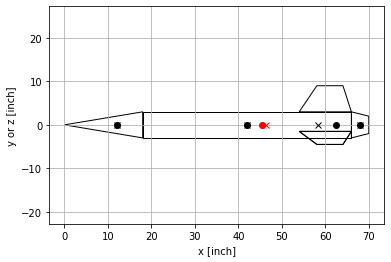

In [2]:
# generate rocket

## First, create a rocket.
r = rp.Rocket(name='Simple Rocket')

## create a nose cone
nc = rp.NoseCone(name='Nose Cone', diameter=6*ureg.inch, fineness=3, material=rp.materials.PLA())
# assign to rocket
r.set_nose_cone(nc)

## create a BodyTube
bt = rp.BodyTube(name = 'Body Tube', diameter=6*ureg.inch, length=48*ureg.inch, wall_thickness=2*ureg.mm, material=rp.materials.Phenolic())
# define its location
bt.set_position(after=nc)
# assign to rocket
r.set_body_tube(bt)

# create a boat tail
boat_tail = rp.Transition(name='Boat Tail', fore_dia=6*ureg.inch, aft_dia=4*ureg.inch, length=4*ureg.inch, material=rp.materials.Phenolic())
# define its location
boat_tail.set_position(after=bt)
# assign to rocket
r.set_boat_tail(boat_tail)

## create the fins
fins = rp.FinSet(name='Fins', n=3, span=6*ureg.inch, root_chord=12*ureg.inch, tip_chord=6*ureg.inch, mid_sweep=10*ureg.degree, tube_dia=6*ureg.inch,  thickness=2*ureg.mm, material=rp.materials.Aluminium())
# define its location
fins.set_position(end_of=bt, offset=-fins.root_chord)
#  assign to rocket
r.set_fins(fins)

# plot the entire rocket
fig = plt.figure()
ax = plt.gca()
r.plot(ax, unit=ureg.inch)
plt.draw()

# describe the rocket
r.describe(describe_components=False)

plt.show()



In [3]:
r.CD(alpha=2*ureg.degree)

0.37951776952621363 <Unit('dimensionless')>

In [4]:
q = rp.Quaternion.from_angle(6.0*np.pi/180.0, np.array([0,1,0]))
q

[[0.99862953]
 [0.        ]
 [0.05233596]
 [0.        ]]

In [5]:
class Environment():
    
    def __init__(self):
        
        # define constants
        self.gamma = 1.4
        self.R = 287*ureg.J/ureg.kg/ureg.degK
        self.ref_temp = 291.15*ureg.degK
        self.ref_visc = 1.827e-7*ureg.Pa/ureg.s
        self.g_0 = 9.80665*ureg.m/ureg.s**2
        self.rho_0 = 1.225*ureg.kg/ureg.m**3
           
    def get_rho(self, z):
        
        try:
            return atm(z).rho #return in si
        except:
            return atm((z.to(ureg.m)).magnitude).rho*ureg.kg/ureg.m**3
    
    def get_mu(self, z):
        
        try:
            return atm(z).mu #return in si
        except:
            return atm((z.to(ureg.m)).magnitude).mu*ureg.Pa*ureg.s

    def get_temp(self, z):
        
        try:
            return atm(z).T #return in si
        except:
            return atm((z.to(ureg.m)).magnitude).T*ureg.degK
    
    def get_speed_of_sound(self, z):
        
        try:
            return atm(z).v_sonic#return in si
        except:
            return atm((z.to(ureg.m)).magnitude).v_sonic*ureg.m/ureg.s
        
    def frozen_wind(t, state):
        
        # function to describe the wind vector (in earth frame) as a function of time or state
        
        return np.array([[1,0,0]]).T

    

In [6]:
env=Environment()

In [7]:
env.get_rho(500)

1.1672725123243854

In [8]:
r.inertia()

(4580.105311485027 <Unit('inch ** 2 * kilogram')>,
 221.4656914751491 <Unit('inch ** 2 * kilogram')>,
 221.4656914751491 <Unit('inch ** 2 * kilogram')>)

In [9]:
class State():
    
    def __init__(self, pos, quaternion, lin_mom, ang_mom, mass):
        
        self.pos = pos
        self.quat = quaternion
        self.lin_mom = lin_mom
        self.ang_mom = ang_mom
        self.mass = mass
        
    def get_state_vector(self):
        
        state = [self.pos, self.quat, self.lin_mom, self.ang_mom, self.mass] 

        return np.vstack([si(s) for s in state])
    
    @classmethod
    def extract(cls, state):
        
        pos = state[0:3] * ureg.m
        quat = state[3:7]
        lin_mom = state[7:10] * ureg.kg*ureg.m/ureg.s
        ang_mom = state[10:13] * ureg.kg*ureg.m**2/ureg.s
        mass = state[13] * ureg.m
        
        return cls(pos, quat, lin_mom, ang_mom, mass)
    
    def __repr__(self):
    
        s  = 'State: \n'
        s += 'Pos:     ' + str(self.pos)  + '\n'
        s += 'Quat:    ' + str(self.quat) + '\n'
        s += 'Lin mom: ' + str(self.lin_mom) + '\n'
        s += 'Ang mom: ' + str(self.ang_mom) + '\n'
        s += 'Mass:    ' + str(self.mass)
        
        return s
    
        
        

In [31]:
pos0 = np.array([[0,0,0]]).T*ureg.m
quat0 = rp.Quaternion.from_angle(6*ureg.degree, [0, 1, 0])
lin_mom0 = np.array([[1,0,0]]).T*ureg.kg*ureg.m/ureg.s
ang_mom0 = np.array([[0,0,0.7]]).T*ureg.kg*ureg.m**2/ureg.s
mass0 = 40*ureg.kg

state0 = State(pos0, quat0, lin_mom0, ang_mom0, mass0)

In [32]:
state0

State: 
Pos:     [[0] [0] [0]] meter
Quat:    [[0.99862953]
 [0.        ]
 [0.05233596]
 [0.        ]]
Lin mom: [[1.0] [0.0] [0.0]] kilogram * meter / second
Ang mom: [[0.0] [0.0] [0.7]] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [33]:
sv=state0.get_state_vector()

In [34]:
s1 = State.extract(sv)

In [35]:
s1

State: 
Pos:     [[0.0] [0.0] [0.0]] meter
Quat:    [[0.99862953]
 [0.        ]
 [0.05233596]
 [0.        ]]
Lin mom: [[1.0] [0.0] [0.0]] kilogram * meter / second
Ang mom: [[0.0] [0.0] [0.7]] kilogram * meter ** 2 / second
Mass:    [40.0] meter

In [36]:
class ConstantWind():
    
    def __init__(self):
        
        self.w0 = 5 * ureg.m/ureg.s
        
    def vector(self, t=None, pos=None):
        
        return np.array([[0, si(self.w0), 0]]).T * ureg.m/ureg.s
    
    
        

In [37]:
wind_constant = ConstantWind()

In [38]:
wind_constant.vector(None, None)

array([[0.],
       [5.],
       [0.]]) <Unit('meter / second')>

In [39]:
class Simulation():
    
    def __init__(self, rocket, environment):
        
        self.rocket = rocket
        self.env = environment
        
        self.ref_axis_R = np.array([[1,0,0]]).T # roll axis
        self.ref_axis_P = np.array([[0,1,0]]).T # pitch axis
        self.ref_axis_Y = np.array([[0,0,1]]).T # yaw axis
        
        return
    
    def dynamics(self, state, control, time, wind):
        
        # everything here is assumed to be in si units
        
        # extract state
        pos = si(state.pos)
        quat = state.quat
        lin_mom = si(state.lin_mom)
        ang_mom = si(state.ang_mom)
        mass = si(state.mass)
        
        # extract extra stuff
        R = quat.rot_matrix()
        RA = unit_vector(R @ self.ref_axis_R) # roll axis
        
        inertia_matrix = self.rocket.inertia_matrix(mass) # get the inertia matrix for a given total rocket mass
        
        # linear velocity
        lin_vel = lin_mom / mass
        
        # angular velocity
        
        ang_vel = R @ la.inv(inertia_matrix) @ R.T @ ang_mom
        
        print(ang_vel)
        
        # rate of change of quaterinon 
        qdot = self.get_qdot(quat, lin_vel, ang_vel)
        
        # get wind speed
        w = si(wind.vector(time, pos))
        
        # calculate angle of attack
        V_cm = lin_vel + w
        
        # calculate all these parameters, automatically performing convergence as necessary
        alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters_converged(V_cm, R, RA, pos, mass, ang_vel)
        
        # TODO (high): continue working here
        
        return alpha, re, mach, xbar, V_omega, V_infty 
        
    def calc_parameters_converged(self, V_cm, R, RA, pos, mass, ang_vel):
        
        if la.norm(ang_vel) < 0.1:
            
            return self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

        else:
            #calculate using V_cm
            alpha_old, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

            # calculate new alpha
            alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)


            # if the difference is large, re-estimate
            while abs(alpha_old - alpha) > 1e-6:

                alpha_old = alpha
                alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)

        return alpha, re, mach, xbar, V_omega, V_infty 

    
    def calc_parameters(self, V_infty, V_cm, R, RA, pos, mass, ang_vel):
        # note, V_infty here is a guess, but the corrected value comes out of the function
            
        alpha = self.calc_alpha(V_infty, RA) #using V_cm as an approximation for V_infty
        
        z = pos[2][0]
        re = self.calc_Re(la.norm(V_infty), z)
        mach = self.calc_Mach(la.norm(V_infty), z)

        xbar = abs((self.rocket.xcp(alpha, re, mach) - self.rocket.xcg(mass*ureg.kg)).m_as(ureg.m))
        
        V_omega = xbar * np.cross(RA, ang_vel, axis=0)# linear speed at the center of pressure due to the rotation rate of the rocket

        V_infty = V_cm + V_omega

        return alpha, re, mach, xbar, V_omega, V_infty

    def calc_Re(self, Vinf, z):
        """Calculate reynolds number for a given vinf and altitude z"""
        
        rho = self.env.get_rho(z)
        mu  = self.env.get_mu(z)
        
        X_rocket = (self.rocket.length()).m_as(ureg.m)
        
        Re = rho*Vinf*X_rocket/mu
        
        return Re
        
        
    def calc_Mach(self, Vinf, z):
        
        a = self.env.get_speed_of_sound(z)
        
        return Vinf/a
    
    def calc_alpha(self, Vinf, RA):
        """Calc alpha for a given wind speed Vinf and roll axis RA"""
        
        return angle_between(Vinf, RA)



        
    def get_qdot(self, quat, lin_vel, ang_vel):
        """Compute the rate of change of the quaternion"""
        s = float(quat.q[0])
        sdot = 0.5 * float( np.dot(ang_vel.T, lin_vel))
        vdot = 0.5 * s * ang_vel + np.cross(ang_vel, ang_vel,axis=0)
        qdot =  np.vstack([sdot, vdot])
        return qdot
    
    
    
    
    

In [40]:
sim = Simulation(r, env)

In [41]:
state0

State: 
Pos:     [[0] [0] [0]] meter
Quat:    [[0.99862953]
 [0.        ]
 [0.05233596]
 [0.        ]]
Lin mom: [[1.0] [0.0] [0.0]] kilogram * meter / second
Ang mom: [[0.0] [0.0] [0.7]] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [42]:
wind_constant.vector(None, None)

array([[0.],
       [5.],
       [0.]]) <Unit('meter / second')>

In [43]:
v=state0.lin_mom/state0.mass + wind_constant.vector()
v

array([[0.025],
       [5.   ],
       [0.   ]]) <Unit('meter / second')>

In [44]:
la.norm(v.m_as('m/s'))/env.get_speed_of_sound(z=0)

0.014693356085789222

In [45]:
sim.dynamics(state0, None, None, wind_constant)

[[0.48467271]
 [0.        ]
 [4.84824735]]


(1.5655793369794446,
 580097.8267762188,
 0.014004961183580992,
 0.04807942601707582,
 array([[ 0.       ],
        [-0.2342598],
        [ 0.       ]]),
 array([[0.025    ],
        [4.7657402],
        [0.       ]]))

In [46]:
r.describe()

Rocket: Simple Rocket

Rocket Details
+--------------------------+--------------+-------------------+
|        Parameter         |    Value     |       Notes       |
+--------------------------+--------------+-------------------+
|        Total Mass        |  1.9803 kg   |                   |
|       Total Length       |  70.0000 in  |                   |
|           X_CG           |  1.152304 m  |                   |
|           X_CP           |   1.1799 m   | At default values |
| Static Margin (calibers) |    ERROR     | At default values |
|            CD            |    0.2894    | At default values |
|           CNa            | 9.0907 / rad | At default values |
+--------------------------+--------------+-------------------+

Component Details
+-----------+------------+------------+---------+-----------------+--------------+
| Component |    Type    |  Material  |   Mass  | Mass Fraction % |     CNa      |
+-----------+------------+------------+---------+-----------------+------

In [30]:

(r.xcp(Mach=0) - r.xcg())

0.02762305134464249 <Unit('meter')>

In [ ]:
r.

In [ ]:
R @ la.inv(im)

In [ ]:
float(state0.quat.q[0])

In [ ]:
r.inertia_matrix()

In [ ]:
import scipy.integrate as spint

In [ ]:
state = np.array([0, 3])

In [ ]:
x, y = state

In [ ]:
def dynamics(state, control, time):
    # extract
    x, xd = state
    u = control
    
    # compute dynamics
    xdd = u
    
    return np.array([xd, xdd])

In [ ]:
def control(state, time):
    
    x, xd = state
    u = -0.1*(x-5) -0.1*xd
        
    return u

In [ ]:
def concise_dynamics(time, state):
    
    u = control(state, time)
    
    dyn = dynamics(state, u, time)
    
    return dyn
    

In [ ]:
concise_dynamics(0, np.array([5,6]))

In [ ]:
state0 = np.array([0, 0])

In [ ]:
sol1=spint.solve_ivp(concise_dynamics, (0, 100), state0, max_step=0.1)
sol2=spint.solve_ivp(concise_dynamics, (0, 100), state0, max_step=1)
sol3=spint.solve_ivp(concise_dynamics, (0, 100), state0)

In [ ]:
sol

In [ ]:
plt.plot(sol.t, sol.y[1,:])

In [ ]:
plt.plot(sol.t, sol.y[0,:],'x')

In [ ]:
plt.plot(np.diff(sol.t))

In [ ]:
plt.plot(sol1.t, sol1.y[0])
plt.plot(sol2.t, sol2.y[0])
plt.plot(sol3.t, sol3.y[0])

In [ ]:
plt.plot(np.diff(sol1.t))
plt.plot(np.diff(sol2.t))
plt.plot(np.diff(sol3.t))